# Capstone Project 1

## Title: Prediction of electricity rates (cost/Kwh) and consumption
### Author: Elizabeth Izarra

### Problem:
Electricity has a very dynamic market price since it is a commodity that is essential for daily life and 
non-storable where generation and demand must be continuously balanced. This is turn make it dependable of the 
weather conditions.    

### Data:

U.S. Energy Information Administration (EIA)

Data Sets:
- Net Generation
- Electricity - Sales (consumption), revenue, prices & customers
- Average cost of fossil fuels delivered by state
- Consumption of fuels used to generate electricity
- Electricity Stock price
 

### ---------------------------------------------------------------------------------------------------

In [9]:
# import the relevant modules
import requests
from pandas.io.json import json_normalize
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def get_data_from_url(API_query):
    # Package the request, send the request and catch the response: r
    r=requests.get(API_query)

    # Inspect the JSON structure, and exploration of how nested it is,
    # as well as the overall structure

    # Decode the JSON data into a dictionary: json_data
    json_data=r.json()
    return json_data

### Exploring U.S. Energy Information Administration (EIA)

In [11]:
API_KEY='a32b693a24d623394f601a1c4262fb10'

In [12]:
#Exploring the available variables
categoryID='0'
#Call the EIA API and pull out the data categories
url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
json_data=get_data_from_url(url)

In [13]:
#Getting the childcategories into a DataFrame
df_cat_IDs_0=json_normalize(json_data['category']['childcategories'])
df_cat_IDs_0

,category_id,name
0,1,Net generation
1,32,Total consumption (Btu)
2,33,Consumption for electricity generation (Btu)
3,34,Consumption for useful thermal output (Btu)
4,35,Total consumption
5,36,Consumption for electricity generation
6,37,Consumption for useful thermal output
7,38,Retail sales of electricity
8,39,Revenue from retail sales of electricity
9,40,Average retail price of electricity


In [14]:
    #Checking for childseries availability
    def childseries_check(cat_idx):
        categoryID=str(df_cat_IDs_0.iloc[cat_idx,0]) 
        

        ##API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])
        
        return(df_ser_ID)

In [15]:
#Getting series 

def get_series(idx, f, start, end):
       
        categoryID=str(df_cat_IDs_0.iloc[idx,0]) 
        variable=df_cat_IDs_0['name'][idx]

        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #getting the series ID for the monthly reporting per state
        #print(f, df_ser_ID.keys())
        ser_IDs=df_ser_ID[df_ser_ID['f'].str.contains(f)]

        #print(ser_IDs.head(), categoryID, variable) 

        #Getting series

        for i in range(len(ser_IDs)):
            #Building API
            seriesID=str(ser_IDs.iloc[i,2]) 
            url='http://api.eia.gov/series/?series_id='+seriesID+'&api_key='+API_KEY+'&start='+start+'&end='+end
            #Retriving data from URL
            json_data=get_data_from_url(url)
            #Extracting information of interest
            h1=json_normalize(json_data,['series'])
            h=json_normalize(json_data,['series',['data']])
           
            #try: print(h1['iso3166']) 
            #except: print('geography='+h1['geography'])
          
        
            #Adding names to columns
            h.columns=['date',variable]
            h['geography']=h1['geography']
            h['unit']=h1['units']
            try: h['iso3166']=h1['iso3166']
            except:h['iso3166']='N/A'
            
            #Chaging column positions
            g=pd.concat([h['date'],h['geography'],h['iso3166'], h[variable],h['unit']],axis=1)
            
            
            #Adding missing data
            g.fillna(method='ffill', inplace=True)
            #seriesID, json_data, g
            
            if i==0:
                df_data_cat=g
            else:

                df_data_cat=df_data_cat.append(g, ignore_index=True, sort=False)
        
        return df_data_cat

In [16]:
#Getting data from Energy Information Administration (EIA)¶


def get_eia_data(variables_idx, f,start, end):
    c_flag=0
    for idx in variables_idx:
        variable=df_cat_IDs_0['name'][idx]
        if  childseries_check(idx).empty:
            print(variable+' - does not have childseries available')
        else:    
            print(variable+' - OK')
            df_data_cat=get_series(idx, f, start, end)
            if c_flag==0:
                df_data=df_data_cat
                c_flag=1
            else:
            
                #Mergin df2 with dictionary Values{code: name} from previous exercise
                df_data=df_data.merge(df_data_cat, how='outer', left_on=['date','geography','iso3166'], 
                                      right_on=['date','geography','iso3166'])
    return df_data
    

#### Exploring Annual Data from 2013

In [17]:
variables_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] #list of indexes of df_cat_IDs_0
f='A' #Frequency can be 'A':Annual, 'Q':Quarter or 'M':Monthly 
start='2013'
end='2013'
df_data=get_eia_data(variables_idx, f,start, end)
df_data.head()


Net generation - OK
Total consumption (Btu) - does not have childseries available
Consumption for electricity generation (Btu) - does not have childseries available
Consumption for useful thermal output (Btu) - does not have childseries available
Total consumption - does not have childseries available
Consumption for electricity generation - does not have childseries available
Consumption for useful thermal output - does not have childseries available
Retail sales of electricity - OK
Revenue from retail sales of electricity - OK
Average retail price of electricity - OK
Plant level data - does not have childseries available
Fossil-fuel stocks for electricity generation - does not have childseries available
Receipts of fossil fuels by electricity plants - does not have childseries available
Receipts of fossil fuels by electricity plants (Btu) - does not have childseries available
Average cost of fossil fuels for electricity generation - does not have childseries available
Average cost of

,date,geography,iso3166,Net generation,unit_x,Retail sales of electricity,unit_y,Revenue from retail sales of electricity,unit_x,Average retail price of electricity,unit_y,Number of customer accounts,unit
0,2013,USA-AK,USA-AK,6496.82164,thousand megawatthours,6268.21201,million kilowatthours,1033.34690,million dollars,16.49,cents per kilowatthour,3.277599e+05,number of customers
1,2013,USA-AL,USA-AL,150572.92386,thousand megawatthours,87852.10702,million kilowatthours,7923.66243,million dollars,9.02,cents per kilowatthour,2.524633e+06,number of customers
2,2013,USA-AR,USA-AR,60322.49214,thousand megawatthours,46683.03401,million kilowatthours,3703.71061,million dollars,7.93,cents per kilowatthour,1.557321e+06,number of customers
3,2013,USA-AZ,USA-AZ,113325.98612,thousand megawatthours,75662.03703,million kilowatthours,7669.32240,million dollars,10.14,cents per kilowatthour,2.947070e+06,number of customers
4,2013,USA-CA,USA-CA,200077.11462,thousand megawatthours,261332.45899,million kilowatthours,37372.30791,million dollars,14.30,cents per kilowatthour,1.510754e+07,number of customers


<function matplotlib.pyplot.show(*args, **kw)>

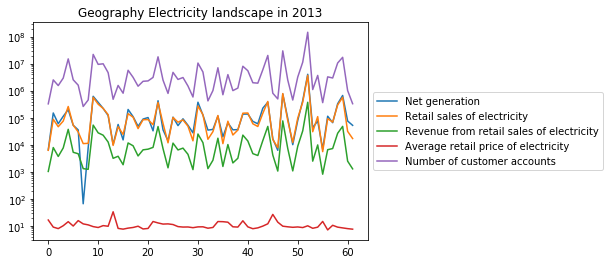

In [18]:
#Geography Electricity landscape in 2013

plot1=df_data.plot(logy=True, title='Geography Electricity landscape in 2013')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plot1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show

### NOAA

In [19]:
Token='AwkqwxasEbHFkzNhMJijIRrdkxVWSkBw'


In [20]:

url='https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets'
response = requests.get(url, headers = { 'token' : Token }, data:{<data>}) 
json_data = response.json()

SyntaxError: invalid syntax (<ipython-input-20-b49084e3f019>, line 3)

In [8]:
json_data

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'uid': 'gov.noaa.ncdc:C00861',
   'mindate': '1763-01-01',
   'maxdate': '2019-04-03',
   'name': 'Daily Summaries',
   'datacoverage': 1,
   'id': 'GHCND'},
  {'uid': 'gov.noaa.ncdc:C00946',
   'mindate': '1763-01-01',
   'maxdate': '2019-03-01',
   'name': 'Global Summary of the Month',
   'datacoverage': 1,
   'id': 'GSOM'},
  {'uid': 'gov.noaa.ncdc:C00947',
   'mindate': '1763-01-01',
   'maxdate': '2018-01-01',
   'name': 'Global Summary of the Year',
   'datacoverage': 1,
   'id': 'GSOY'},
  {'uid': 'gov.noaa.ncdc:C00345',
   'mindate': '1991-06-05',
   'maxdate': '2019-04-09',
   'name': 'Weather Radar (Level II)',
   'datacoverage': 0.95,
   'id': 'NEXRAD2'},
  {'uid': 'gov.noaa.ncdc:C00708',
   'mindate': '1994-05-20',
   'maxdate': '2019-04-06',
   'name': 'Weather Radar (Level III)',
   'datacoverage': 0.95,
   'id': 'NEXRAD3'},
  {'uid': 'gov.noaa.ncdc:C00821',
   'mindate': '2010-01-01',
   

In [ ]:

headers